In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

In [69]:
# !pip install mpi4py

Analytical solution:

$$ \int_0^1 \lambda \cdot e^{-\lambda x} dx = -\lambda \cdot \frac{1}{\lambda} \cdot e^{-\lambda x} \Big|_0^1 = 1 - e^{-\lambda}$$


Compute an integral using the trapezoid rule
●Split the job between processes and use Reduce 
collective communication
●Check the accuracy when
taking more nodes
(i.e. smaller step)
●Check the speedup 
when taking more processes

In [4]:
l = 1
an_int = 1 - np.exp(-l)
print(f"Answer: {an_int}")

Answer: 0.6321205588285577


In [5]:
lin = np.linspace(0,1,10000)
trap_int = 0
for i in range(9999):
    trap_int += (exponential_pdf(lin[i]) + exponential_pdf(lin[i+1]))*(lin[i+1]-lin[i])/2
print(f"Answer: {trap_int}")

Answer: 0.6321205593554283


In [34]:
%%writefile test.py
from mpi4py import MPI
import numpy as np

def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

l = 1
an_int = 1 - np.exp(-l)

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

num_iter = 10000000

left = rank//size
right = (rank+1)//size
lin = np.linspace(left,right,int(num_iter//size))
expon_lin = exponential_pdf(lin)
trap_int = np.sum((expon_lin[1:] + expon_lin[:-1]) * (lin[1:] - lin[:-1]) / 2)

recvbuf = comm.reduce(trap_int, op=MPI.SUM, root = 0)


end = MPI.Wtime()

if rank==0:
    print(recvbuf)
    print(end-start)
    print(abs(an_int - recvbuf))


Overwriting test.py


In [35]:
!mpirun --allow-run-as-root -n 1 python test.py

0.6321205588285587
0.3492918350000309
9.992007221626409e-16


In [36]:
!mpirun --allow-run-as-root -n 2 python test.py

0.6321205588285598
0.2714300519999142
2.1094237467877974e-15


In [37]:
!mpirun --allow-run-as-root -n 3 python test.py

0.6321205588285622
0.2314693430000716
4.551914400963142e-15


In [38]:
!mpirun --allow-run-as-root -n 4 python test.py

0.632120558828566
0.45284616499998265
8.326672684688674e-15


In [39]:
!mpirun --allow-run-as-root -n 5 python test.py

0.6321205588285707
0.40427542700012964
1.2989609388114332e-14


In [40]:
!mpirun --allow-run-as-root -n 6 python test.py

0.6321205588285768
0.31689320499981477
1.9095836023552692e-14


In [41]:
!mpirun --allow-run-as-root -n 7 python test.py

0.6321205588285836
0.4368564859998969
2.5979218776228663e-14


In [42]:
!mpirun --allow-run-as-root -n 8 python test.py

0.6321205588285913
0.40929520499980754
3.3639757646142243e-14


In [43]:
!mpirun --allow-run-as-root -n 9 python test.py

0.6321205588286005
0.4088609699999779
4.285460875053104e-14


In [44]:
!mpirun --allow-run-as-root -n 10 python test.py

0.6321205588286105
0.4570491430001766
5.284661597215745e-14


Text(0, 0.5, 'Speedup')

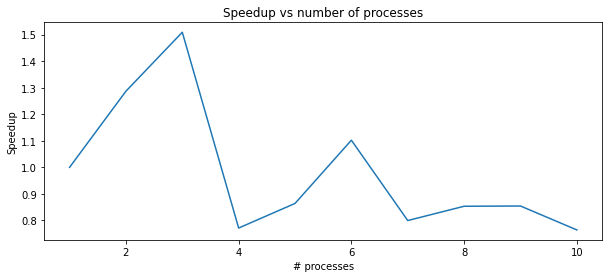

In [45]:
speedup = np.array([0.3492918350000309,
                    0.2714300519999142,
                    0.2314693430000716,
                    0.45284616499998265,
                    0.40427542700012964,
                    0.31689320499981477,
                    0.4368564859998969,
                    0.40929520499980754,
                    0.4088609699999779,
                    0.4570491430001766])
speedup = speedup[0] / speedup
plt.figure(figsize=(10,4))
plt.title('Speedup vs number of processes')
plt.plot(np.arange(1,11), speedup)
plt.xlabel('# processes')
plt.ylabel('Speedup')

In [65]:
%%writefile test.py
from mpi4py import MPI
import numpy as np

def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

l = 1
an_int = 1 - np.exp(-l)

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

num_iter = 100000000

left = rank//size
right = (rank+1)//size
lin = np.linspace(left,right,int(num_iter//size))
expon_lin = exponential_pdf(lin)
trap_int = np.sum((expon_lin[1:] + expon_lin[:-1]) * (lin[1:] - lin[:-1]) / 2)

recvbuf = comm.reduce(trap_int, op=MPI.SUM, root = 0)


end = MPI.Wtime()

if rank==0:
    print(recvbuf)
    print(end-start)
    print(abs(an_int - recvbuf))


Overwriting test.py


In [66]:
!mpirun --allow-run-as-root -n 3 python test.py

0.6321205588285557
2.789522747000092
1.9984014443252818e-15


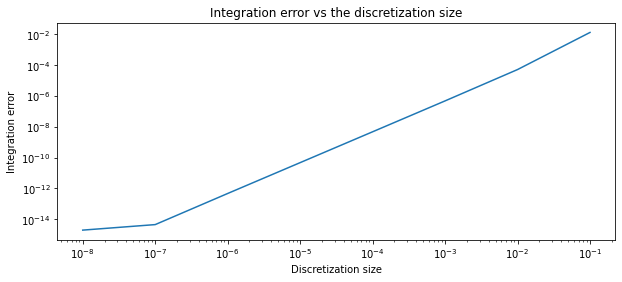

In [68]:
errors = np.array([0.01311463132061963,
                    5.14412655150398e-05,
                    4.779059484816273e-07,
                    4.7446991890964796e-09,
                    4.741285142273455e-11,
                    4.740652315149418e-13,
                    4.551914400963142e-15,
                    1.9984014443252818e-15])
plt.figure(figsize=(10,4))
plt.title('Integration error vs the discretization size')
plt.plot(1/(10**np.arange(1,9)), errors)
plt.xlabel('Discretization size')
plt.ylabel('Integration error')
plt.xscale('log')
plt.yscale('log')